In [1]:
import pandas as pd
import numpy as np
import re
import argparse
pd.options.display.max_rows = 200

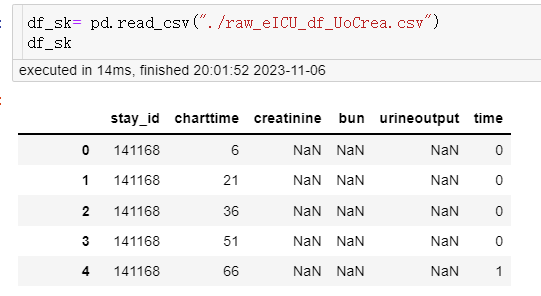

In [2]:
df_sk= pd.read_csv("./raw_eICU_df_UoCrea.csv")
df_sk = df_sk[["stay_id","charttime","urineoutput",'time']]
#df_sk = df_sk.dropna(how='all', subset=['urineoutput'])
df_sk.loc[(df_sk['urineoutput'] > 2500), 'urineoutput'] /= 10
df_sk.loc[(df_sk['urineoutput'] > 4500), 'urineoutput'] = np.nan
df_sk.loc[(df_sk['urineoutput'] <= 0), 'urineoutput'] = np.nan
df_sk = df_sk[(df_sk["time"]<= 24*10) & (df_sk["time"]>= -24*7)]
df_uo = df_sk.groupby(["stay_id","time"]).agg({"urineoutput":"sum"}).reset_index()
df_uo = df_uo.sort_values(["stay_id","time"])
df_uo.head(2)

,stay_id,time,urineoutput
0,141168,0,0.0
1,141168,1,0.0


In [3]:
# 填补时间为连续的
df = df_uo
df = df.set_index('time')
tmp_df = pd.DataFrame()
for i,j in df.groupby(["stay_id"]):
    j = j.reindex(range(j.index.min(), j.index.max() + 1)).reset_index()
    tmp_df = pd.concat([tmp_df,j],axis=0)
df_uo_addtime = tmp_df
df_uo_addtime["stay_id"] = df_uo_addtime["stay_id"].fillna(method='ffill')
df_uo_addtime.to_csv("./tmp_uo_addtime.csv",index=False)

In [7]:
## 获取过去6小时，12小时，24小时的尿量 ##
df_uo = pd.read_csv("./tmp_uo_addtime.csv")
df_uo["uo_b6hr"] = df_uo.groupby('stay_id')["urineoutput"].rolling(window=6,min_periods=1).sum().reset_index(level=0, drop=True)
df_uo["uo_b12hr"] = df_uo.groupby('stay_id')["urineoutput"].rolling(window=12,min_periods=1).sum().reset_index(level=0, drop=True)
df_uo["uo_b24hr"] = df_uo.groupby('stay_id')["urineoutput"].rolling(window=24,min_periods=1).sum().reset_index(level=0, drop=True)
df_uo.to_csv("./uo_for_AKI.csv",index=False)
df_uo.head(2)

,time,stay_id,urineoutput,uo_b6hr,uo_b12hr,uo_b24hr
0,0,141168.0,0.0,0.0,0.0,0.0
1,1,141168.0,0.0,0.0,0.0,0.0


In [8]:
## 获取体重 ##
df_demo = pd.read_csv("/public/hanl/jupyter_dir/database/eicu/clean/eicu_icudetails.csv")
df_demo = df_demo[["stay_id","weight"]]

uo = pd.read_csv("./uo_for_AKI.csv")
uo = df_uo
## 获取尿量速率 ##
uo = pd.merge(uo,df_demo,how="left",on="stay_id")
uo["uo_b6hr_r"] =  round(uo["uo_b6hr"] / 6/uo["weight"],1)
uo["uo_b12hr_r"] =  round(uo["uo_b12hr"] / 12/uo["weight"],1)
uo["uo_b24hr_r"] =  round(uo["uo_b24hr"] / 24/uo["weight"],1)

## 通过尿量定义AKI ##
uo.loc[((uo['time'] > 2) & (uo['uo_b6hr'] > 0) & (uo['uo_b6hr_r']<0.5)), 'aki_stage_uo'] = 1
uo.loc[((uo['time'] > 5) & (uo['uo_b12hr'] > 0) & (uo['uo_b12hr_r']<0.5)), 'aki_stage_uo'] = 2
uo.loc[((uo['time'] > 5) & (uo['uo_b12hr'] > 0) & (uo['uo_b12hr_r']==0)), 'aki_stage_uo'] = 3
uo.loc[((uo['time'] > 11) & (uo['uo_b24hr'] > 0) & (uo['uo_b24hr_r']<0.3)), 'aki_stage_uo'] = 3

In [9]:
uo.to_csv("aki_stage_uo.csv",index=False)
uo.head()

,time,stay_id,urineoutput,uo_b6hr,uo_b12hr,uo_b24hr,weight,uo_b6hr_r,uo_b12hr_r,uo_b24hr_r,aki_stage_uo
0,0,141168.0,0.0,0.0,0.0,0.0,84.3,0.0,0.0,0.0,NaN
1,1,141168.0,0.0,0.0,0.0,0.0,84.3,0.0,0.0,0.0,NaN
2,2,141168.0,0.0,0.0,0.0,0.0,84.3,0.0,0.0,0.0,NaN
3,3,141168.0,0.0,0.0,0.0,0.0,84.3,0.0,0.0,0.0,NaN
4,4,141168.0,0.0,0.0,0.0,0.0,84.3,0.0,0.0,0.0,NaN
